In [10]:
##用于可视化
%matplotlib inline  

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from keras.models import Model #泛型模型
from keras import regularizers
from keras.layers import Dense, Input

In [2]:
mnist = input_data.read_data_sets('/home/liuzixuan/机器学习/深度/小练习/MNIST_data',one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /home/liuzixuan/机器学习/深度/小练习/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /home/liuzixuan/机器学习/深度/小练习/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /home/liuzixuan/机器学习/深度/小练习/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /home/liuzixuan/机器学习/深度/小练习/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [6]:
x_train, _, x_test, y_test = mnist.train.images,mnist.train.labels,mnist.test.images,mnist.test.labels
# 数据预处理
x_train = x_train.astype('float32') / 255.        # 归一化
x_test = x_test.astype('float32') / 255.        # 归一化
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))
print(x_train.shape)
print(x_test.shape)

# 压缩特征维度至2维
encoding_dim = 2

(55000, 784)
(10000, 784)


In [16]:
def kl_divergence(p,p_hat,eps=1e-7):
    p_0 = tf.clip_by_value(p,eps,1)
    p_1 = tf.clip_by_value(1-p,eps,1)
    p_hat_0 = tf.clip_by_value(p_hat,eps,1)
    p_hat_1 = tf.clip_by_value(1-p_hat,eps,1)
    
    res = p_0 * (tf.log(p_0) - tf.log(p_hat_0)) + p_1 * (tf.log(p_1) - tf.log(p_hat_1))
    res = tf.reduce_mean(res)
    return res

In [21]:
input_img = Input(shape=(784,))
# 编码层
encoded = Dense(128, activation='relu', activity_regularizer=regularizers.l1(10e-6))(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)
encoder_output = Dense(encoding_dim)(encoded)

# 解码层
decoded = Dense(10, activation='relu')(encoder_output)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation=tf.nn.sigmoid)(decoded)

# 构建自编码模型
autoencoder = Model(inputs=input_img, outputs=decoded)

# 构建编码模型
encoder = Model(inputs=input_img, outputs=encoder_output)

# 编译自动编码器
#loss = encoder.losses(kl_divergence(0.05,0.05))
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()
encoder.summary()

# 进行训练
autoencoder.fit(x_train, x_train, epochs=10, batch_size=256, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_42 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_43 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 22        
_________________________________________________________________
dense_45 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_46 (Dense)             (None, 64)                704       
__________

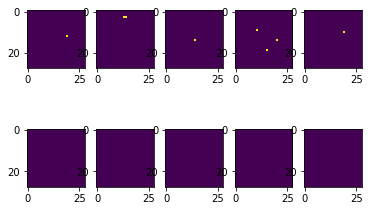

In [19]:
# 画图
encoded_imgs = encoder.predict(x_test)

decoded_imgs = autoencoder.predict(x_test)

for j in range(10):
    plt.subplot(2,5,j+1)
    img = x_test[j] if j < 5 else decoded_imgs[j-5]
    img = (img * 255).astype(np.uint8).reshape([28,28])
    plt.imshow(img)
plt.show()